<a href="https://colab.research.google.com/github/jouinisihem/Multimodal-Medical-Visual-Question-Answering-VQA-/blob/main/inf%C3%A9rence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
#Importation des librairies necessaires
import transformers
import os

from PIL import Image
import torch
import torch.nn as nn
from typing import Dict, List, Optional, Tuple
from transformers import (
    # Prétraitement 
    AutoTokenizer, AutoFeatureExtractor,
    # Modèles de texte et d'image (maintenant, les transformateurs d'image comme ViTModel, DeiTModel, BEiT peuvent également être chargés à l'aide d'AutoModel)
    AutoModel )

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Informations supplémentaires lors de l'utilisation de cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda:0
Tesla T4


In [ ]:
#Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def loadAnswerSpace() -> List[str]:
    with open(os.path.join('/content/drive/MyDrive/Sihem Jouini /VQA-Med2019/answer_space.txt')) as f:
        answer_space = f.read().splitlines()
    return answer_space

# Charger le vocabulaire de toutes les réponses
answer_space = loadAnswerSpace()

In [ ]:
class MultimodalVQAModel(nn.Module):
    def __init__(self, pretrained_text_name, pretrained_image_name, num_labels= len(answer_space),intermediate_dim= 512,dropout=0.5):
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        #encodeurs d'image et de texte
        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)

        # Couche de fusion 
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            # ReLu (Unité Linéaire Rectifiée)==>fonction d'activation
            nn.ReLU(),
            # La méthode du dropout consiste à  désactiver  des sorties de neurones aléatoirement(0.5 pour les couches cachées)
            nn.Dropout(0.5),
        )

        #classifieur
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )

        logits = self.classifier(fused_output)
        
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

In [ ]:
def tokenizeQuestion(text_encoder, question, device) -> Dict:
  tokenizer = transformers.AutoTokenizer.from_pretrained(text_encoder)
  encoded_text = tokenizer(
      text=[question],
      add_special_tokens = True,
      padding='longest',
      max_length=24,
      truncation=True,
      return_tensors='pt',
      return_token_type_ids=True,
      return_attention_mask=True
      )
  return {
      "input_ids": encoded_text['input_ids'].to(device),
      "token_type_ids": encoded_text['token_type_ids'].to(device),
      "attention_mask": encoded_text['attention_mask'].to(device),
    }

In [ ]:
question = "what abnormality is seen in this image ?"

question = question.lower().replace("?", "").strip() # Remove the question mark (if present) & extra spaces before tokenizing
tokenized_question = tokenizeQuestion("dmis-lab/biobert-v1.1", question, device)
tokenizer = transformers.AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
tokenized_sequence = tokenizer.tokenize(question)
inputs = tokenizer(question)

encoded_sequence = inputs["input_ids"]
decoded_sequence = tokenizer.decode(encoded_sequence)
print(decoded_sequence)
print(tokenized_sequence)
tokenized_question

[CLS] what abnormality is seen in this image [SEP]
['what', 'abnormal', '##ity', 'is', 'seen', 'in', 'this', 'image']


{'input_ids': tensor([[  101,  1184, 22832,  1785,  1110,  1562,  1107,  1142,  3077,   102]],
        device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [ ]:
def featurizeImage(image_encoder, img_path, device) -> Dict:
  featurizer = transformers.AutoFeatureExtractor.from_pretrained(image_encoder)
  processed_images = featurizer(
      images=[Image.open(img_path).convert('RGB')],
      return_tensors="pt",
      )
  return {
      "pixel_values": processed_images['pixel_values'].to(device),
      }

what type of contrast


Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


question:	 what type of contrast
Predicted Answer:	 iv


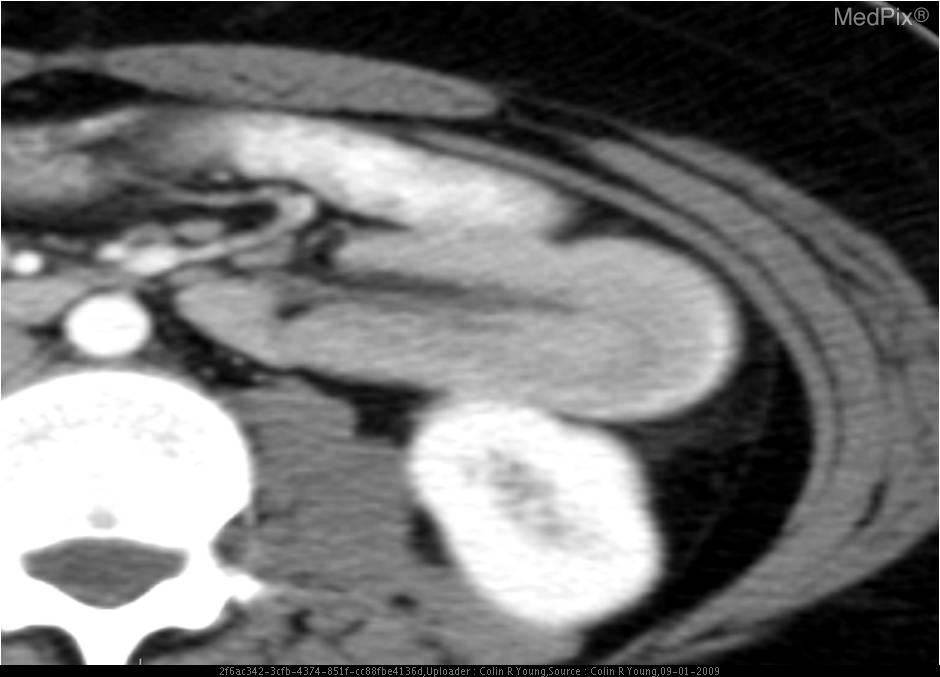

In [ ]:
img_path = "/content/drive/MyDrive/Sihem Jouini /VQA-Med2019/images/synpic50696.jpg"
question = input()

# Load the vocabulary of all answers
#answer_space = loadAnswerSpace()

# Tokenize the question & featurize the image
question = question.lower().replace("?", "").strip() # Remove the question mark (if present) & extra spaces before tokenizing
tokenized_question = tokenizeQuestion("dmis-lab/biobert-v1.1", question, device)
featurized_img = featurizeImage("microsoft/swin-tiny-patch4-window7-224", img_path, device)

# Load the model checkpoint 
model = MultimodalVQAModel(
    pretrained_text_name="dmis-lab/biobert-v1.1",
    pretrained_image_name="microsoft/swin-tiny-patch4-window7-224",
    num_labels=len(answer_space),
    intermediate_dim=512
    )
checkpoint = os.path.join("/content/drive/MyDrive/Sihem Jouini /VQA-Med2019/checkpoint/checkpoint-4400", "pytorch_model.bin")
model.load_state_dict(torch.load(checkpoint))
model.to(device)

# model.eval() permet de passer le modèle en mode évaluation
model.eval()

# Obtain the prediction from the model
input_ids = tokenized_question["input_ids"].to(device)
token_type_ids = tokenized_question["token_type_ids"].to(device)
attention_mask = tokenized_question["attention_mask"].to(device)
pixel_values = featurized_img["pixel_values"].to(device)
output = model(input_ids, pixel_values, attention_mask, token_type_ids)

# Obtain the answer from the answer space
preds = output["logits"].argmax(axis=-1).cpu().numpy()
p=torch.tensor(preds)
answer = answer_space[preds[0]]

print("question:\t" ,question)
print("Predicted Answer:\t", answer)
Image.open(os.path.join(img_path ))